____Ноутбук с генерации статей на основе оригинальных новостей New York Times. Используется модель DeepSeek-v3 (API)____


* 1. Инициализация и загрузка данных

* 2. Генерация статей

* 3. Анализ статей

* 4. Доработка статей на основе фидбека модели

* 5. Доработка статей на основе фидбека модели, итерация 2

* 6. Доработка статей на основе фидбека модели, итерация 3

* 7. Обработка всех статей (полный цикл)

* 8. Сравнение оригинальных статей и сгенерирвоанных 

In [1]:
from utils_create_news import  save_s3, try_load, clean_titile_space
from models.deepseekv3 import dsv3_rewrite_news
from IPython.display import clear_output
from dotenv import load_dotenv
from openai import OpenAI
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import re

/Users/dan/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/6p/bshr1_dj3_7_gk1krflr4lzm0000gn/T/matplotlib-4q4gkqs7 because there was an issue with the default path (/Users/dan/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


# 1. Инициализация и загрузка данных

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [3]:
# DeepSeek client
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

In [3]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [ ]:
# Загрузим оригинальные новости
papers_nyt_clean = try_load(file_path=PATH+'data/', file_name='papers_nyt_clean.pkl', client_s3=client_s3)
len(papers_nyt_clean)

# 2. Генерация статей

In [14]:
papers_nyt_clean_keys = list(papers_nyt_clean.keys())[:10]
error_key = []

# Ранее переписанные новости deepseek 
# papers_nyt_rewrite_news = try_load(file_path=PATH+'data/', file_name='papers_nyt_rewrite_news.pkl', client_s3=client_s3)
papers_nyt_rewrite_news = {}

for i, key in enumerate(papers_nyt_clean_keys):

    if key not in papers_nyt_rewrite_news.keys():
        try:
            print(f'---START {i}---')

            paper = papers_nyt_clean[key]

            ans = dsv3_rewrite_news(client=client, query=paper)
            ans = ans.choices[0].message.content

            clear_output(wait=True)

            papers_nyt_rewrite_news[key] = [paper, ans]

            print(f'---START {i}---')

            print('Новость номер 1:')
            print(paper)

            print('Новость номер 2:')
            print(ans)
                
        except:
            error_key.append(key)


---START 9---
Новость номер 1:
President Biden has weathered years of scandals surrounding his son. But people close to both men say the president has refused to treat him as a political liability. Follow our live coverage of the verdict in Hunter Biden’s gun trial. President Biden wakes up every day to a list of concerns he must address as commander in chief. He receives updates from his aides each morning on the war in Gaza and the Russian invasion of Ukraine. He calls his advisers to quiz them about the latest polls and headlines. But at the top of that list, people who know him say, is a concern that nags at him as a father: the legal problems of his son, Hunter Biden. Hunter Biden, 54, is scheduled to stand trial this week in a federal court in Delaware on charges that he failed to disclose his drug addiction on a form when buying a gun in 2018. His legal team has called the charges politically motivated, and his attorneys intend to challenge the notion that Hunter Biden improperl

# 3. Анализ статей

### 3.1 Анализ глазами + LLM as a judge

In [19]:
# Сравнение статей оригинальных от сгенерировванных
for key in papers_nyt_clean_keys:

    txt = papers_nyt_rewrite_news[key][1]
    print('Статья сгенерированная:')
    print(txt.replace('\n', ' '))

    txt = papers_nyt_rewrite_news[key][0]
    print('Статья оригинальная:')
    print(txt.replace('\n', ' '))
    
    print('\n')

Статья сгенерированная:
Ohio has moved to resolve a potential ballot crisis that threatened to leave President Joe Biden off the state’s November election ballot, with the Republican-controlled General Assembly passing a legislative fix that adjusts the certification deadline to align with the Democratic National Convention schedule. Governor Mike DeWine, a Republican, is expected to sign the bill into law this weekend following a final legal review, according to his office.   The issue arose after Ohio Secretary of State Frank LaRose, also a Republican, warned that Biden could be excluded from the ballot because the Democratic Party’s official nomination process, set for August, would occur after Ohio’s August 7 deadline for certifying presidential candidates. This procedural conflict had raised concerns that Biden might not appear on the ballot in one of the nation’s key battleground states—a scenario that could have disrupted the electoral landscape.   Ohio has faced similar challen

### 3.2 Анализ длинны статей

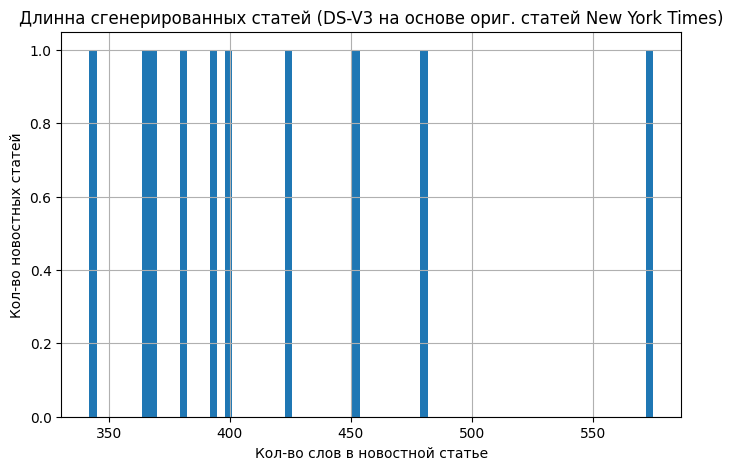

Generated paper - NYT
Среднее: 417.80, медиана: 395.00, квантиль 0,05: 352.35, квантиль 0,95: 532.25


In [20]:
cnt_len_memmory = []
for paper in papers_nyt_rewrite_news.values():
    paper = paper[1]
    cnt_len_memmory.append(
        len(paper.split(' '))
    )

cnt_len_memmory = pd.Series(cnt_len_memmory)

# График
plt.figure(figsize=(8,5))
cnt_len_memmory.hist(bins=75)

plt.title('Длинна сгенерированных статей (DS-V3 на основе ориг. статей New York Times)')
plt.xlabel('Кол-во слов в новостной статье')
plt.ylabel('Кол-во новостных статей')
plt.show()

# Статистика
dsv3_mean, dsv3_median, dsv3_q05, dsv3_q95 = cnt_len_memmory.mean(), cnt_len_memmory.median(), cnt_len_memmory.quantile(0.05), cnt_len_memmory.quantile(0.95)
print('Generated paper - NYT')
print(f'Среднее: {dsv3_mean:.2f}, медиана: {dsv3_median:.2f}, квантиль 0,05: {dsv3_q05:.2f}, квантиль 0,95: {dsv3_q95:.2f}')

# 4. Доработка статей на основе фидбека модели, итерация 1

**https://arxiv.org/pdf/2303.17651**

## 4.1 Пример

In [21]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper, dsv3_rewrite_dsv3_paper

In [22]:
error_key = []
updatet_items = set()

for i, key in enumerate(papers_nyt_clean_keys):

    if key not in updatet_items:
        try:
            print(f'---START {i}---')

            # Статья для обработки
            orig_paper = papers_nyt_rewrite_news[key][0]
            gen_paper = papers_nyt_rewrite_news[key][1]
            print('Статья до изменений:', gen_paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper(client=client, query=gen_paper)
            eval_paper = eval_paper.choices[0].message.content.replace('\n', '')
            print('Оценка статьи:', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper(client=client, news_article=gen_paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print(final_paper)

            clear_output(wait=True)

            papers_nyt_rewrite_news[key] = [orig_paper, gen_paper, eval_paper, final_paper]
            updatet_items.add(key)

            print(f'---START {i}---')

            print('Статья до изменений:', orig_paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)
                
        except:
            error_key.append(key)

---START 9---
Статья до изменений: President Biden has weathered years of scandals surrounding his son. But people close to both men say the president has refused to treat him as a political liability. Follow our live coverage of the verdict in Hunter Biden’s gun trial. President Biden wakes up every day to a list of concerns he must address as commander in chief. He receives updates from his aides each morning on the war in Gaza and the Russian invasion of Ukraine. He calls his advisers to quiz them about the latest polls and headlines. But at the top of that list, people who know him say, is a concern that nags at him as a father: the legal problems of his son, Hunter Biden. Hunter Biden, 54, is scheduled to stand trial this week in a federal court in Delaware on charges that he failed to disclose his drug addiction on a form when buying a gun in 2018. His legal team has called the charges politically motivated, and his attorneys intend to challenge the notion that Hunter Biden impro

In [23]:
for key in papers_nyt_clean_keys:
    (orig_paper, gen_paper, eval_paper, final_paper) = papers_nyt_rewrite_news[key]

    print(f'Оригинальные статья: {orig_paper}')
    print(f'Сгенерированная статья: {gen_paper}')
    print(f'Оценка признаков LLM у сгенерирвоанной статьи: {eval_paper}')
    print(f'Доработанная статья: {final_paper}')
    print('--------------------------------')

Оригинальные статья: The bill, which Gov. Mike DeWine, a Republican, is expected to sign this weekend, appeared to end the possibility that President Biden would not be on the state’s ballot in November. The Ohio General Assembly has passed a legislative fix that ensures President Biden will be on the state’s ballot in November, averting a crisis that had been brewing for weeks over what is typically a minor procedural issue. The secretary of state in Ohio, a Republican, had said that he planned to exclude Mr. Biden from the ballot because the president would not be officially nominated by his party until after a state deadline for certifying presidential nominees. That had threatened the possibility that the president would not be on the ballot in all 50 states. The General Assembly resolved the issue by passing a bill that pushes back the deadline to accommodate the date of the Democratic nominating convention. Gov. Mike DeWine, a Republican, is expected to sign the bill over the wee

# 5. Доработка статей на основе фидбека модели, итерация 2

In [36]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper_v2, dsv3_rewrite_dsv3_paper_v2

In [41]:
error_key = []
updatet_items = set()

for i, key in enumerate(papers_nyt_clean_keys):

    if key not in updatet_items:

        try:
            print(f'---START {i}---')

            # Статья для обработки
            data = papers_nyt_rewrite_news[key]
            original_paper = data[0]
            last_paper = data[3]
            print('Статья до изменений:', last_paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=last_paper, original_query=original_paper)
            eval_paper = eval_paper.choices[0].message.content
            print('Замечания к статье', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=last_paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            data += [eval_paper, final_paper]

            papers_nyt_rewrite_news[key] = data

            print(f'---START {i}---')

            print('Статья до изменений:', original_paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)
                
        except:
            error_key.append(key)

---START 9---
Статья до изменений: President Biden has weathered years of scandals surrounding his son. But people close to both men say the president has refused to treat him as a political liability. Follow our live coverage of the verdict in Hunter Biden’s gun trial. President Biden wakes up every day to a list of concerns he must address as commander in chief. He receives updates from his aides each morning on the war in Gaza and the Russian invasion of Ukraine. He calls his advisers to quiz them about the latest polls and headlines. But at the top of that list, people who know him say, is a concern that nags at him as a father: the legal problems of his son, Hunter Biden. Hunter Biden, 54, is scheduled to stand trial this week in a federal court in Delaware on charges that he failed to disclose his drug addiction on a form when buying a gun in 2018. His legal team has called the charges politically motivated, and his attorneys intend to challenge the notion that Hunter Biden impro

In [42]:
for key in papers_nyt_clean_keys:
    (orig_paper, _, _, paper_before_update, eval_paper, final_paper) = papers_nyt_rewrite_news[key]

    print(f'Оригинальные статья: {orig_paper}')
    print(f'Сгенерированная статья: {paper_before_update}')
    print(f'Оценка признаков LLM у сгенерирвоанной статьи: {eval_paper}')
    print(f'Доработанная статья: {final_paper}')
    print('--------------------------------')

Оригинальные статья: The bill, which Gov. Mike DeWine, a Republican, is expected to sign this weekend, appeared to end the possibility that President Biden would not be on the state’s ballot in November. The Ohio General Assembly has passed a legislative fix that ensures President Biden will be on the state’s ballot in November, averting a crisis that had been brewing for weeks over what is typically a minor procedural issue. The secretary of state in Ohio, a Republican, had said that he planned to exclude Mr. Biden from the ballot because the president would not be officially nominated by his party until after a state deadline for certifying presidential nominees. That had threatened the possibility that the president would not be on the ballot in all 50 states. The General Assembly resolved the issue by passing a bill that pushes back the deadline to accommodate the date of the Democratic nominating convention. Gov. Mike DeWine, a Republican, is expected to sign the bill over the wee

# 6. Доработка статей на основе фидбека модели, итерация 3

In [40]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper_v3, dsv3_rewrite_dsv3_paper_v3

In [44]:
error_key = []
updatet_items = set()

for i, key in enumerate(papers_nyt_clean_keys):

    if key not in updatet_items:

        try:
            print(f'---START {i}---')

            # Статья для обработки
            data = papers_nyt_rewrite_news[key]
            last_paper = data[5]
            print('Статья до изменений:', last_paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=last_paper)
            eval_paper = eval_paper.choices[0].message.content
            print('Замечания к статье', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=last_paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            data.append(eval_paper)
            data.append(final_paper)

            papers_nyt_rewrite_news[key] = data

            print(f'---START {i}---')

            print('Статья до изменений:', last_paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)
                
        except:
            error_key.append(key)

---START 9---
Статья до изменений: President Joe Biden has faced countless challenges during his decades in public life, but few are as personally wrenching as watching his son prepare for a federal trial. On Monday, Hunter Biden will appear in a Wilmington courtroom to face charges of making false statements about his drug use when purchasing a firearm in 2018. Legal observers note the case is unusual—prosecutions for such offenses are rare without accompanying violent crimes—yet it has taken on outsized political significance during an election year already marked by legal battles involving prominent figures.The president has maintained a steadfast public presence even as his son's legal troubles unfold. Those close to the family describe private moments where Biden checks in regularly, maintaining the quiet support that has characterized their relationship through Hunter's struggles with addiction. The two were recently seen riding bicycles near their Delaware home, a familiar routi

In [54]:
for key in papers_nyt_clean_keys:
    (orig_paper, gen_news, eval, gen_on_eval, eval_paper, gen_paper, final_paper) = papers_nyt_rewrite_news[key]

    papers_nyt_rewrite_news[key] = [orig_paper, gen_news, eval, gen_on_eval, eval_paper, gen_paper, 'ERROR', final_paper]

In [48]:
for key in papers_nyt_clean_keys:
    (orig_paper, _, _, _, paper_before_update, eval_paper, final_paper) = papers_nyt_rewrite_news[key]

    print(f'Оригинальные статья: {orig_paper}')
    print(f'Сгенерированная статья: {paper_before_update}')
    print(f'Оценка признаков LLM у сгенерирвоанной статьи: {eval_paper}')
    print(f'Доработанная статья: {final_paper}')
    print('--------------------------------')

Оригинальные статья: The bill, which Gov. Mike DeWine, a Republican, is expected to sign this weekend, appeared to end the possibility that President Biden would not be on the state’s ballot in November. The Ohio General Assembly has passed a legislative fix that ensures President Biden will be on the state’s ballot in November, averting a crisis that had been brewing for weeks over what is typically a minor procedural issue. The secretary of state in Ohio, a Republican, had said that he planned to exclude Mr. Biden from the ballot because the president would not be officially nominated by his party until after a state deadline for certifying presidential nominees. That had threatened the possibility that the president would not be on the ballot in all 50 states. The General Assembly resolved the issue by passing a bill that pushes back the deadline to accommodate the date of the Democratic nominating convention. Gov. Mike DeWine, a Republican, is expected to sign the bill over the wee

# 7. Обработка всех статей (полный цикл)

In [56]:
save_s3(pickle_data=papers_nyt_rewrite_news, object_key='papers_nyt_rewrite_news.pkl', client_s3=client_s3)

with open(PATH+'/data/papers_nyt_rewrite_news.pkl', 'wb') as file: 
    pickle.dump(papers_nyt_rewrite_news, file)

In [65]:
papers_nyt_clean_keys = list(papers_nyt_clean.keys())

# Оригинальная статья
# papers_nyt_rewrite_news = try_load(file_path=PATH+'data/', file_name='papers_nyt_rewrite_news.pkl', client_s3=client_s3)

for i, key in enumerate(papers_nyt_clean_keys[:1000]):

        if key not in papers_nyt_rewrite_news.keys():

                print(f'---START {i}---')

                ### 1. Оригинальная статья
                orig_paper = papers_nyt_clean[key]
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')

                ### 2. Переписанная статья
                edit_paper_0 = dsv3_rewrite_news(client=client, query=orig_paper)
                edit_paper_0 = edit_paper_0.choices[0].message.content
                edit_paper_0 = edit_paper_0.replace('\n\n', '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')

                ### 3. RF этап 1
                # 3.1 Оценка статьи
                eval_paper_1 = dsv3_evaluate_dsv3_paper(client=client, query=edit_paper_0)
                eval_paper_1 = eval_paper_1.choices[0].message.content.replace('\n', '')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')

                # 3.2 Редактирования статьи
                edit_paper_1 = dsv3_rewrite_dsv3_paper(client=client, news_article=edit_paper_0, suggestions=eval_paper_1)
                edit_paper_1 = edit_paper_1.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_1 = clean_titile_space(edit_paper_1)
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')

                ### 4. RF этап 2
                # 4.1 Оценка статьи
                eval_paper_2 = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=edit_paper_1, original_query=orig_paper)
                eval_paper_2 = eval_paper_2.choices[0].message.content.replace('\n', '')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')

                # 4.2 Редактирование статьи
                edit_paper_2 = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=edit_paper_1, suggestions=eval_paper_2)
                edit_paper_2 = edit_paper_2.choices[0].message.content.replace('\n\n', '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')

                ### 5. RF этап 3
                # 5.1 Оценка статьи
                eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
                eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

                # 5.2 Редактирование статьи
                edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
                edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

                papers_nyt_rewrite_news[key] = [
                    orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3
                    ]

                clear_output(wait=True)

                print(f'---START {i}---')
                
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')
                
                print('\n------------------------------------------------------------------------------------------------------------------')

                if len(papers_nyt_rewrite_news) % 10 == 0:
                    save_s3(pickle_data=papers_nyt_rewrite_news, object_key='papers_nyt_rewrite_news.pkl', client_s3=client_s3)

                    with open(PATH+'/data/papers_nyt_rewrite_news.pkl', 'wb') as file: 
                        pickle.dump(papers_nyt_rewrite_news, file)

---START 999---
1. [ID 0] Оригинальная статья: Funds from the ransomware attacks on hospitals subsidized military espionage activities, prosecutors say. A federal grand jury on Thursday indicted a North Korean man on charges of stealing huge amounts of data from the computers of American military bases and defense contractors, as well as NASA and several Asian companies, in the latest sign of North Korea’s malicious cybercrime and espionage abilities. Federal prosecutors accused the man, Rim Jong Hyok, of working with unnamed co-conspirators to steal data in 2022 from four unnamed American defense contractors and from Randolph Air Force Base in Texas and Robins Air Force Base in Georgia. The indictment also said that the North Koreans had extracted data from computers in NASA’s inspector general office over three months that year. In what experts called standard practice for North Korea’s cyberoperatives, Mr. Rim and his collaborators subsidized their espionage with money procured in r

In [63]:
save_s3(pickle_data=papers_nyt_rewrite_news, object_key='papers_nyt_rewrite_news.pkl', client_s3=client_s3)

with open(PATH+'/data/papers_nyt_rewrite_news.pkl', 'wb') as file: 
    pickle.dump(papers_nyt_rewrite_news, file)

# 8. Сравнение оригинальных статей и сгенерирвоанных 

In [5]:
papers_nyt_rewrite_news = try_load(file_path=PATH+'data/', file_name='papers_nyt_rewrite_news.pkl', client_s3=client_s3)
papers_nyt_rewrite_news_keys = list(papers_nyt_rewrite_news.keys())

In [8]:
for _ in range(3):

    key = np.random.choice(papers_nyt_rewrite_news_keys)
    print(key)
    
    text = papers_nyt_rewrite_news[key][0].replace('\n', ' ')
    print(f'Оригинальная статья: {text}')
    text = papers_nyt_rewrite_news[key][1].replace('\n', ' ')
    print(f'Сгенерированная статья: {text}')

    text = papers_nyt_rewrite_news[key][2].replace('\n', ' ')
    print(f'Self-Refine оценка (1): {text}')
    text = papers_nyt_rewrite_news[key][3].replace('\n', ' ')
    print(f'Self-Refine генерация (1): {text}')

    text = papers_nyt_rewrite_news[key][4].replace('\n', ' ')
    print(f'Self-Refine оценка (2): {text}')
    text = papers_nyt_rewrite_news[key][5].replace('\n', ' ')
    print(f'Self-Refine генерация (2): {text}')

    text = papers_nyt_rewrite_news[key][6].replace('\n', ' ')
    print(f'Self-Refine оценка (3): {text}')
    text = papers_nyt_rewrite_news[key][7].replace('\n', ' ')
    print(f'Self-Refine генерация (3): {text}', '\n\n')

What to Watch for at the NATO Summit This Week
Оригинальная статья: Russia-Ukraine War All eyes are on President Biden, but looming over the meeting is the possibility that Vladimir Putin might pull a stunt to disrupt the gathering. By Michael CrowleyJulian E. BarnesEric Schmitt and John Ismay As NATO leaders gather in Washington starting Tuesday, they will celebrate the strength of their alliance on its 75th anniversary while confronting deep uncertainty about its future. In recent years, Russia’s aggression against Ukraine has given NATO, founded after World War II to defend Europe from the Soviet Union, a renewed sense of purpose. But the alliance also faces grave threats, including from right-wing skeptics who are gaining power in nations such as Germany and France. And the potential return to the White House of Donald J. Trump, who has derided NATO and even mused about withdrawing the United States from the alliance, has raised alarms among its members. Here’s what to watch for du